In [ ]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import imageio
import tifffile as tiff
import tensorflow as tf 

In [33]:
TEST_PATH = "dataset/kaggle_3m/TCGA_CS_4943_20000902"

In [34]:
# List all tif files in the directory
files = glob(f"{TEST_PATH}/*.tif")

# Separate mask and image files
image_files = [f for f in files if '_mask' not in f]
mask_files = [f for f in files if '_mask' in f]

In [35]:
# Sort the files
images = sorted(image_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
masks = sorted(mask_files, key=lambda x: int(x.split('_')[-2].split('.')[-1]))

In [36]:
images, masks

(['dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_1.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_2.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_3.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_4.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_5.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_6.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_7.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_8.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_9.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_10.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_11.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_12.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_20000902\\TCGA_CS_4943_20000902_13.tif',
  'dataset/kaggle_3m/TCGA_CS_4943_

In [37]:
def create_gif(images, masks, gif_path='mri_with_masks.gif', duration=0.5):
    frames = []
    for i in range(len(images)):
        image_path = images[i]
        mask_path = masks[i]
        
        image = plt.imread(image_path)
        mask = plt.imread(mask_path)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, cmap='jet', alpha=0.5)
        ax.set_title('MRI Image with Mask Overlay')
        ax.axis('off')
        
        fig.canvas.draw()
        
        # Convert plot to image
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        frames.append(frame)
        plt.close(fig)
    
    # Save frames as a gif
    imageio.mimsave(gif_path, frames, duration=duration)

create_gif(images, masks, gif_path='tumor.gif', duration=0.01)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_768\541332416.py:20: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


### MRI Images with Mask Overlays

The following GIF shows the MRI images with their corresponding mask overlays:

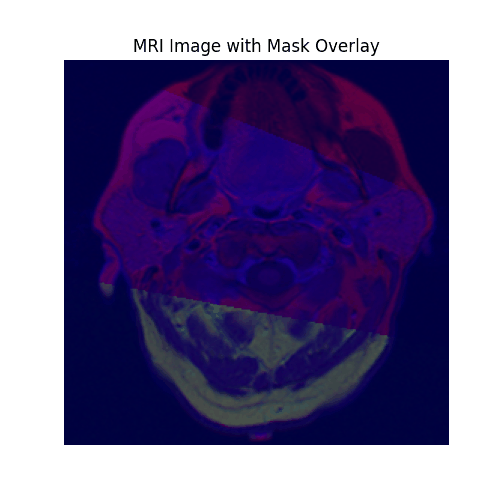

In [ ]:
# Load model
model = tf.keras.models.load_model('model/BrainMRISegment-Predictor.keras')

In [ ]:


# function that takes both image & mask path and return the image
def process_path(image_path, mask_path):
    img = tiff.imread(image_path)
    img = img[:, :, 0:3]
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tiff.imread(mask_path)
    # Check if mask is 2D or 3D
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def predict(model, image):
    pred_mask = model.predict(image[tf.newaxis, ...])
    pred_mask = create_mask(pred_mask)
    return pred_mask

def create_gif_with_predictions(images, masks, model, gif_path='mri_with_predictions.gif', duration=0.5):
    frames = []
    for i in range(len(images)):
        image_path = images[i]
        mask_path = masks[i]
        
        image, mask = process_path(image_path, mask_path)
        image, mask = preprocess(image, mask)
        pred_mask = predict(model, image)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        ax1.imshow(image, cmap='gray')
        ax1.imshow(mask, cmap='jet', alpha=0.5)
        ax1.set_title('MRI Image with True Mask Overlay')
        ax1.axis('off')
        
        ax2.imshow(image, cmap='gray')
        ax2.imshow(pred_mask, cmap='jet', alpha=0.5)
        ax2.set_title('MRI Image with Predicted Mask Overlay')
        ax2.axis('off')
        
        fig.canvas.draw()

        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave(gif_path, frames, duration=duration)

create_gif_with_predictions(images, masks, model, gif_path='tumor_with_predictions.gif', duration=0.01)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


C:\Users\PMLS\AppData\Local\Temp\ipykernel_768\1134837866.py:36: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
